In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.6/615.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import sys
import cv2 as cv
import numpy as np
from ultralytics import YOLO
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data'

In [ ]:
#predictions = model.predict(source='/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/images/test', hide_labels=True, line_thickness=6, save=True, save_txt=True);

In [ ]:
!pip install albumentations

In [ ]:
!pip install pybboxes

In [ ]:
# get_album_bb
def get_album_bb_list(yolo_bbox, class_names):
    album_bb =[]
    str_bbox_list = yolo_bbox.split(' ')
    for index, value in enumerate(str_bbox_list):
        if index == 0:  # class number is placed at index 0
            class_name = class_names[int(value)]
        else:
            album_bb.append(float(value))
    album_bb.append(class_name)  # [x_center, y_center, width, height, class_name]
    return album_bb


def get_album_bb_lists(yolo_str_labels, classes):
    album_bb_lists = []
    yolo_list_labels = yolo_str_labels.split('\n')
    for yolo_str_label in yolo_list_labels:
        if len(yolo_str_label) > 0:
            album_bb_list = get_album_bb_list(yolo_str_label, classes)
            album_bb_lists.append(album_bb_list)
    return album_bb_lists


def get_bboxes_list(inp_lab_pth, classes):
    yolo_str_labels = open(inp_lab_pth, "r").read()
    if yolo_str_labels:
        if "\n" in yolo_str_labels:
            print("multi-objs")
            album_bb_lists = get_album_bb_lists(yolo_str_labels, classes)
        else:
            print("single line ")
            album_bb_lists = get_album_bb_list(yolo_str_labels, classes)
            album_bb_lists = [album_bb_lists]  # require 2d list in alumbentation function
    else:
        print("No object")
        album_bb_lists = []
    return album_bb_lists

In [ ]:
# album_to_yolo_bb
def single_obj_bb_yolo_conversion(transformed_bboxes, class_names):
    if len(transformed_bboxes):
        class_num = class_names.index(transformed_bboxes[-1])
        bboxes = list(transformed_bboxes)[:-1] # .insert(0, '0')
        bboxes.insert(0, class_num)
    else:
        bboxes = []
    return bboxes


def multi_obj_bb_yolo_conversion(aug_labs, class_names):
    yolo_labels = []
    for aug_lab in aug_labs:
        bbox = single_obj_bb_yolo_conversion(aug_lab, class_names)
        yolo_labels.append(bbox)
    return yolo_labels


In [ ]:
# save_augs
import cv2
import os


def save_aug_lab(transformed_bboxes, lab_pth, lab_name):
    lab_out_pth = os.path.join(lab_pth, lab_name)
    with open(lab_out_pth, 'w') as output:
        for bbox in transformed_bboxes:
            updated_bbox = str(bbox).replace(',', ' ').replace('[', '').replace(']', '')
            output.write(updated_bbox + '\n')


def save_aug_image(transformed_image, out_img_pth, img_name):
    out_img_path = os.path.join(out_img_pth,img_name)
    cv2.imwrite(out_img_path, transformed_image)

In [ ]:
# validate_results
import cv2
import pybboxes as pbx
from google.colab.patches import cv2_imshow


def draw_yolo(image, labels):
    H, W = image.shape[:2]
    for label in labels:
        yolo_normalized = label[1:]
        box_voc = pbx.convert_bbox(tuple(yolo_normalized), from_type="yolo", to_type="voc", image_size=(W,H))
        cv2.rectangle(image, (box_voc[0], box_voc[1]),
                    (box_voc[2], box_voc[3]), (0, 0, 255), 1)
    cv2.imwrite("output_vis.png", image)
    cv2_imshow( image)
    cv2.waitKey(0)


In [ ]:
#apply_album_aug
import albumentations as A


def apply_aug(image, bboxes, out_lab_pth, out_img_pth, transformed_file_name, classes):
    transform = A.Compose([
        A.RandomCrop(width=300, height=300),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=-1),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0),
        A.CLAHE(clip_limit=(0, 1), tile_grid_size=(8, 8), always_apply=True),
        A.Resize(300, 300)
    ], bbox_params=A.BboxParams(format='yolo'))
    transformed = transform(image=image, bboxes=bboxes)
    transformed_image = transformed['image']
    transformed_bboxes = transformed['bboxes']
    tot_objs = len(bboxes)
    if tot_objs != 0:
        if tot_objs > 1:
            transformed_bboxes = multi_obj_bb_yolo_conversion(transformed_bboxes, classes)
            save_aug_lab(transformed_bboxes, out_lab_pth, transformed_file_name + ".txt")
        else:
            transformed_bboxes = [single_obj_bb_yolo_conversion(transformed_bboxes[0], classes)]
            save_aug_lab(transformed_bboxes, out_lab_pth, transformed_file_name + ".txt")
        save_aug_image(transformed_image, out_img_pth, transformed_file_name + ".png")
        draw_yolo(transformed_image, transformed_bboxes)
    else:
        print("label file is empty")

In [ ]:
CONSTANTS = {
    'inp_img_pth' : '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/images/aug_inp_img',
    'inp_lab_pth' : '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/aug_inp_lab',
    'out_img_pth' : '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/images/aug_out_img',
    'out_lab_pth' : '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/aug_out_lab',
    'transformed_file_name' : 'aug',
    'CLASSES' : ['Craters']
}

In [ ]:
imgs = os.listdir(CONSTANTS["inp_img_pth"])
imgs[0]

'mars_crater--8-_jpg.rf.85af0fa193ad2d5b0087dc48ec7341c6.jpg'

In [ ]:
file_name = '.'.join(imgs[0].split('.')[:-1])
file_name

'mars_crater--8-_jpg.rf.85af0fa193ad2d5b0087dc48ec7341c6'

In [ ]:
lab_pth = '.'.join(file_name)+'.txt'
lab_pth

'mars_crater--8-_jpg.rf.85af0fa193ad2d5b0087dc48ec7341c6.txt'

In [ ]:
def run_pipeline():
    imgs = os.listdir(CONSTANTS["inp_img_pth"])
    for img_file in imgs:
        file_name = '.'.join(img_file.split('.')[:-1])
        print(file_name)
        aug_file_name = file_name + "_" + CONSTANTS["transformed_file_name"]
        image = cv2.imread(os.path.join(CONSTANTS["inp_img_pth"], img_file))
        lab_pth = os.path.join(CONSTANTS["inp_lab_pth"], file_name + '.txt')
        album_bboxes = get_bboxes_list(lab_pth, CONSTANTS['CLASSES'])
        apply_aug(image, album_bboxes, CONSTANTS["out_lab_pth"],  CONSTANTS["out_img_pth"], aug_file_name, CONSTANTS['CLASSES'])

mars_crater--8-_jpg.rf.85af0fa193ad2d5b0087dc48ec7341c6
single line 


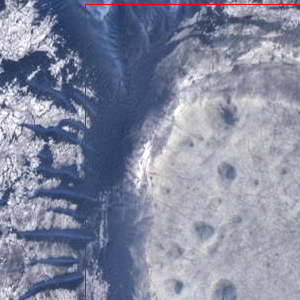

mars_crater--56-_jpg.rf.6f0dcbff4ea66014aef178b840d29238
multi-objs


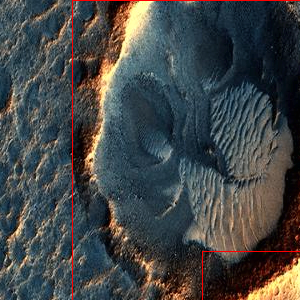

mars_crater--57-_jpg.rf.a783aaeaf00ae5d57bec64438050285f
No object
label file is empty
mars_crater--9-_jpg.rf.64378015a647ef92689e24ea103644cd
multi-objs


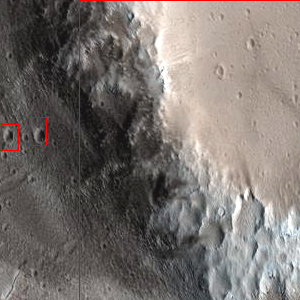

mars_crater--59-_jpg.rf.4f609e19d4f7f9987f696183edd87e99
No object
label file is empty
mars_crater--68-_jpg.rf.e503921bd751aed3cfd662cda03ab6b6
multi-objs


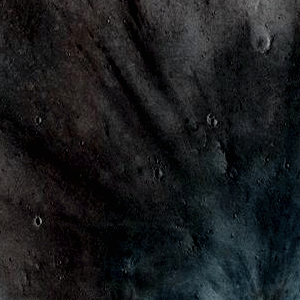

mars_crater--85-_jpg.rf.344998b46a84deb2b8802cdae98c5282
multi-objs


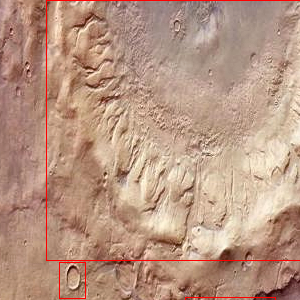

mars_crater--84-_jpg.rf.dcfe6c285ac885441a1c95d818b188e1
multi-objs


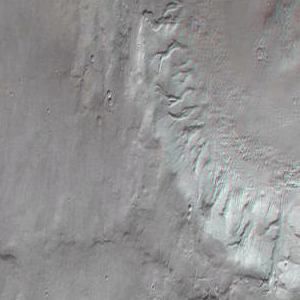

mars_crater--83-_jpg.rf.3a468d2f7715d1cf73d5a31d385e0c34
multi-objs


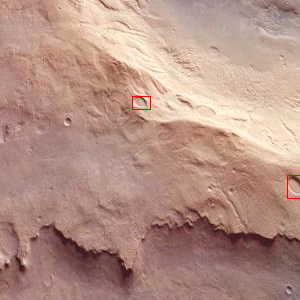

mars_crater--96-_jpg.rf.6dca8e5264f81785f8d718f92f9e4475
multi-objs


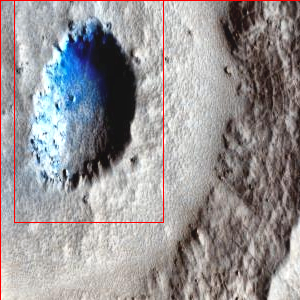

mars_crater--93-_jpg.rf.7426ac666cec74a8b0bc15d550b8699b
multi-objs


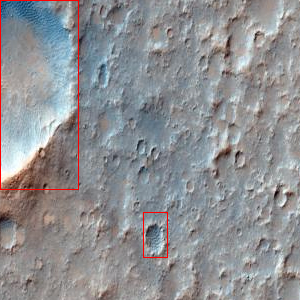

mars_crater--88-_jpg.rf.2f3b851dec48a94bfccc6519b4a45859
multi-objs


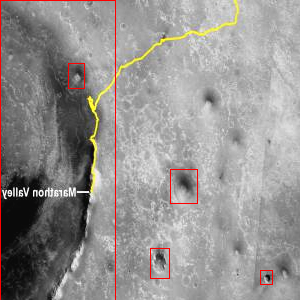

mars_crater--10-_jpg.rf.585b1aa305997e3055e86fcac72a806b
multi-objs


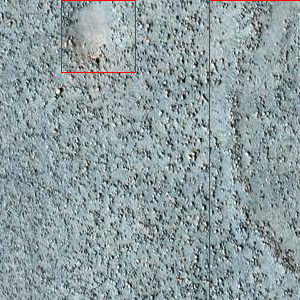

mars_crater--2-_jpg.rf.a65bb7ee68968509ac0b28df75e1f251
single line 


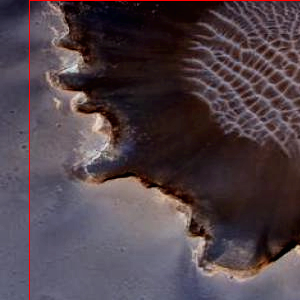

mars_crater--15-_jpg.rf.c669035a909b835be84fa4fc67bf3f40
single line 


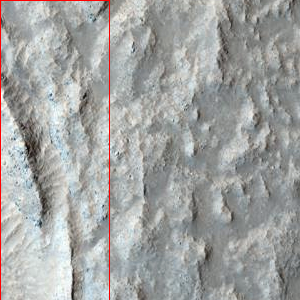

mars_crater--24-_jpg.rf.4614bb6844fda70ea8a3b4f515cb7e8f
single line 


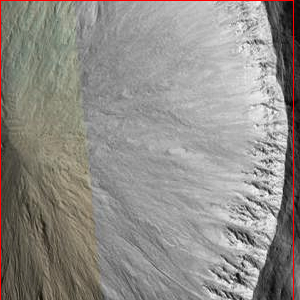

mars_crater--22-_jpg.rf.3ed23daa3923c22a459593cb449a7336
single line 


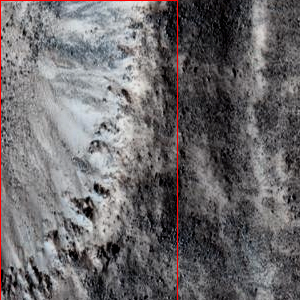

mars_crater--26-_jpg.rf.e34074ddcd6c44fa17b7a7689f7ddfa4
multi-objs


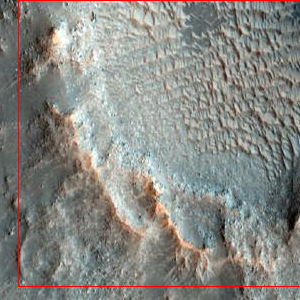

mars_crater--34-_jpg.rf.5617051b3d6a801330f8d4f7df9e3239
single line 


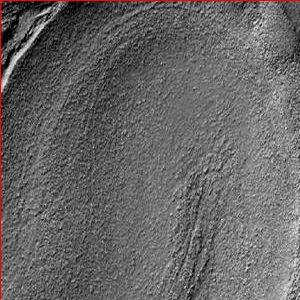

mars_crater--35-_jpg.rf.826bc4b2a3a69c48144834f40d92439f
multi-objs


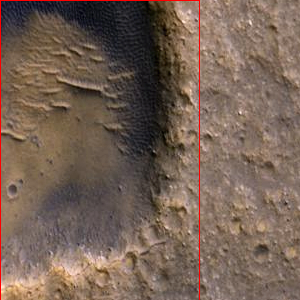

mars_crater--55-_jpg.rf.452ea46e23156b2c86433eb9054b1a6a
multi-objs


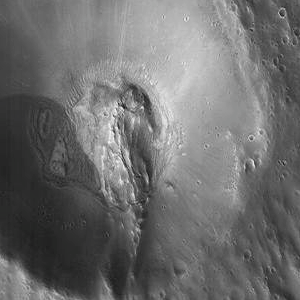

mars_crater--41-_jpg.rf.5b367c681ccf0dfa9c5fddf287926d83
single line 


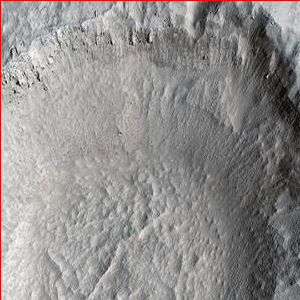

mars_crater--42-_jpg.rf.0cea1f9d9cf45fb141abf4e9aaae4c84
No object
label file is empty
mars_crater--44-_jpg.rf.627a604f51a4479d1f1660c5cf2af5c4
multi-objs


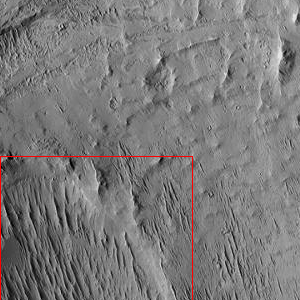

mars_crater--110-_jpg.rf.593f6a3d9aed98e7a08955e700765222
single line 


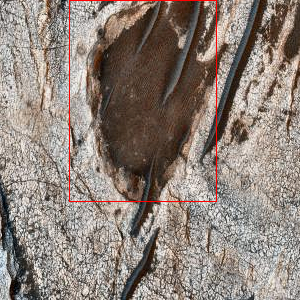

mars_crater--105-_jpg.rf.338dccc756e50430460dfb6f6191d1c5
single line 


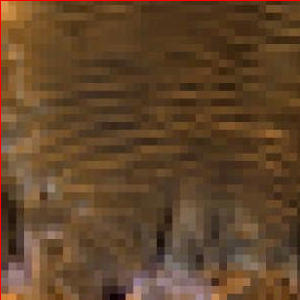

mars_crater--101-_jpg.rf.8f4eb1c77ab9e64d2fd691a6e0fcd3ec
multi-objs


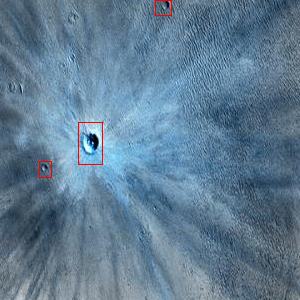

mars_crater--45-_jpg.rf.d69fa5e159ad8e5fe17b96deaba99c18
No object
label file is empty
mars_crater--50-_jpg.rf.02be16d199897982df8e6ea8f3e5818f
single line 


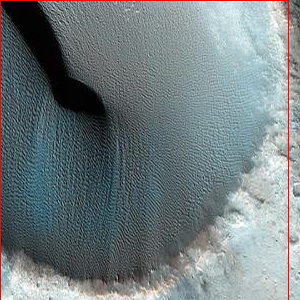

mars_crater--120-_jpg.rf.a870131b0b5974e8351a32ade2d5f0f3
multi-objs


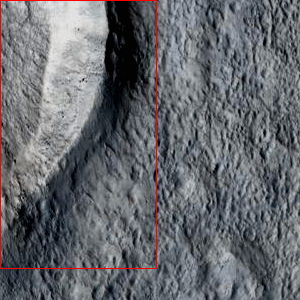

In [ ]:
run_pipeline()

In [ ]:
model = YOLO('yolov8n.yaml')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [ ]:
results = model.train(data=os.path.join(root_dir, 'config.yaml'), epochs=75, optimizer='SGD')

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/config.yaml, epochs=75, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=None, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fal

In [ ]:
val = model.val(data=os.path.join(root_dir, 'config.yaml'), plots=True, val=False)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/valid.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.61s/it]
                   all         26        202       0.62      0.386       0.45      0.234
Speed: 4.2ms preprocess, 320.5ms inference, 0.0ms loss, 5.0ms postprocess per image
Results saved to runs/detect/val


In [ ]:
val

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb9323f1b70>
fitness: 0.2553146433740718
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.23368])
names: {0: 'Craters'}
plot: True
results_dict: {'metrics/precision(B)': 0.6204049110419079, 'metrics/recall(B)': 0.38613861386138615, 'metrics/mAP50(B)': 0.45006185252633096, 'metrics/mAP50-95(B)': 0.23367606457937629, 'fitness': 0.2553146433740718}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 4.179092553945688, 'inference': 320.5039959687453, 'loss': 0.00031177814190204325, 'postprocess': 4.950578396136944}

In [ ]:
val75 = model.val(data=os.path.join(root_dir, 'config.yaml'), plots=True, val=False)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/valid.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]
                   all         26        202      0.648      0.465      0.517      0.287
Speed: 4.5ms preprocess, 335.2ms inference, 0.0ms loss, 3.8ms postprocess per image
Results saved to runs/detect/val


In [ ]:
val75

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb932146230>
fitness: 0.3100372536761863
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.28699])
names: {0: 'Craters'}
plot: True
results_dict: {'metrics/precision(B)': 0.6481052654052951, 'metrics/recall(B)': 0.46534653465346537, 'metrics/mAP50(B)': 0.5174338797988633, 'metrics/mAP50-95(B)': 0.2869931841069999, 'fitness': 0.3100372536761863}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 4.481783280005822, 'inference': 335.1521767102755, 'loss': 0.0002292486337515024, 'postprocess': 3.7525800558236933}

In [ ]:
val75_1 = model.val(data=os.path.join(root_dir, 'config.yaml'), plots=True, val=False, conf=0.1)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
val: Scanning /content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/valid.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.03s/it]
                   all         26        202      0.648      0.465       0.56      0.339
Speed: 2.9ms preprocess, 285.4ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val2


In [ ]:
val75_1

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb9323b56c0>
fitness: 0.3611348263922831
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.33909])
names: {0: 'Craters'}
plot: True
results_dict: {'metrics/precision(B)': 0.6481052654052951, 'metrics/recall(B)': 0.46534653465346537, 'metrics/mAP50(B)': 0.5595443269643785, 'metrics/mAP50-95(B)': 0.33908932632871697, 'fitness': 0.3611348263922831}
save_dir: PosixPath('runs/detect/val2')
speed: {'preprocess': 2.8974092923677883, 'inference': 285.4484044588529, 'loss': 0.0002109087430513822, 'postprocess': 0.45160146859975964}

In [ ]:
results100 = model.train(data=os.path.join(root_dir, 'config.yaml'), epochs=100, optimizer='SGD')

Ultralytics YOLOv8.0.190 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

In [ ]:
results100

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7eb9322218d0>
fitness: 0.341994190058147
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.31774])
names: {0: 'Craters'}
plot: True
results_dict: {'metrics/precision(B)': 0.6609386746409016, 'metrics/recall(B)': 0.5099009900990099, 'metrics/mAP50(B)': 0.5602967825538343, 'metrics/mAP50-95(B)': 0.3177383464475151, 'fitness': 0.341994190058147}
save_dir: PosixPath('runs/detect/train3')
speed: {'preprocess': 1.8670375530536358, 'inference': 207.3903909096351, 'loss': 0.00017422896165114181, 'postprocess': 1.4754350368793194}

In [ ]:
val100 = model.val(data=os.path.join(root_dir, 'config.yaml'), plots=True, val=False, conf=0.1)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/valid.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.19s/it]
                   all         26        202      0.661       0.51      0.601      0.364
Speed: 2.7ms preprocess, 301.1ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val3


In [ ]:
import pickle

In [ ]:
pickle.dump(results100, open('model100.pkl','wb'))

In [ ]:
results200 = model.train(data=os.path.join(root_dir, 'config.yaml'), epochs=200, optimizer='SGD')

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/config.yaml, epochs=200, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

In [ ]:
val200 = model.val(data=os.path.join(root_dir, 'config.yaml'), plots=True, val=False, conf=0.1)

Ultralytics YOLOv8.0.173 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data/labels/valid.cache... 26 images, 2 backgrounds, 0 corrupt: 100%|██████████| 26/26 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.56s/it]
                   all         26        202      0.684      0.644      0.683      0.412
Speed: 3.7ms preprocess, 249.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val


In [ ]:
!scp -r /content/runs '/content/drive/MyDrive/Colab Notebooks/Astronomical DS/Internship/data'